<a href="https://www.kaggle.com/code/naciyenur/fruits-and-vegetables-cnn?scriptVersionId=264217178" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os

count = 0
for dirname, _, filenames in os.walk('/kaggle/input/fruit-and-vegetable-image-recognition'):
    count += len(filenames)
print(f"Toplam dosya sayısı: {count}")


Toplam dosya sayısı: 3825


In [2]:
import os
from collections import Counter

# Dataset klasörü
dataset_path = '/kaggle/input/fruit-and-vegetable-image-recognition'

# Tüm dosya uzantılarını toplama
extensions = []
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        ext = os.path.splitext(filename)[1].lower()  
        extensions.append(ext)

# Kaç tane her uzantı var?
ext_counts = Counter(extensions)
print("Dosya uzantıları ve sayıları:")
for ext, count in ext_counts.items():
    print(f"{ext}: {count}")


Dosya uzantıları ve sayıları:
.jpg: 3535
.png: 223
.jpeg: 67


****VERİ ÖN İŞLEME AŞAMASI****

In [3]:
# Gerekli kütüphanelerin import edilmesi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

2025-09-26 20:50:49.804725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758919850.017438      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758919850.075502      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
dataset_path = '/kaggle/input/fruit-and-vegetable-image-recognition'

In [5]:
# dosyaları dataframe aktarıyoruz
filepaths = []
labels = []

In [6]:
for root, _, files in os.walk(dataset_path):
    for file in files:
        filepaths.append(os.path.join(root, file))
        labels.append(os.path.basename(root))  

df = pd.DataFrame({'filepath': filepaths, 'label': labels})

In [7]:
 df.nunique()

filepath    3825
label         36
dtype: int64

In [8]:
df["label"].value_counts()
#hangi sınıfta kaç tane görüntü var görüyoruz 

label
peas             120
pineapple        119
grapes           119
turnip           118
spinach          117
soy beans        117
lettuce          116
onion            114
cucumber         114
garlic           112
cabbage          112
tomato           112
sweetcorn        111
capsicum         109
pear             109
bell pepper      109
kiwi             108
beetroot         108
corn             107
jalepeno         107
mango            106
chilli pepper    106
eggplant         104
watermelon       104
paprika          103
lemon            102
carrot           101
raddish          100
cauliflower       99
pomegranate       99
potato            97
banana            93
sweetpotato       89
orange            88
ginger            88
apple             88
Name: count, dtype: int64

In [9]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3825 entries, 0 to 3824
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  3825 non-null   object
 1   label     3825 non-null   object
dtypes: object(2)
memory usage: 59.9+ KB


,filepath,label
0,/kaggle/input/fruit-and-vegetable-image-recogn...,capsicum
1,/kaggle/input/fruit-and-vegetable-image-recogn...,capsicum
2,/kaggle/input/fruit-and-vegetable-image-recogn...,capsicum
3,/kaggle/input/fruit-and-vegetable-image-recogn...,capsicum
4,/kaggle/input/fruit-and-vegetable-image-recogn...,capsicum


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
# veri görselleştirme kütüphaneleri

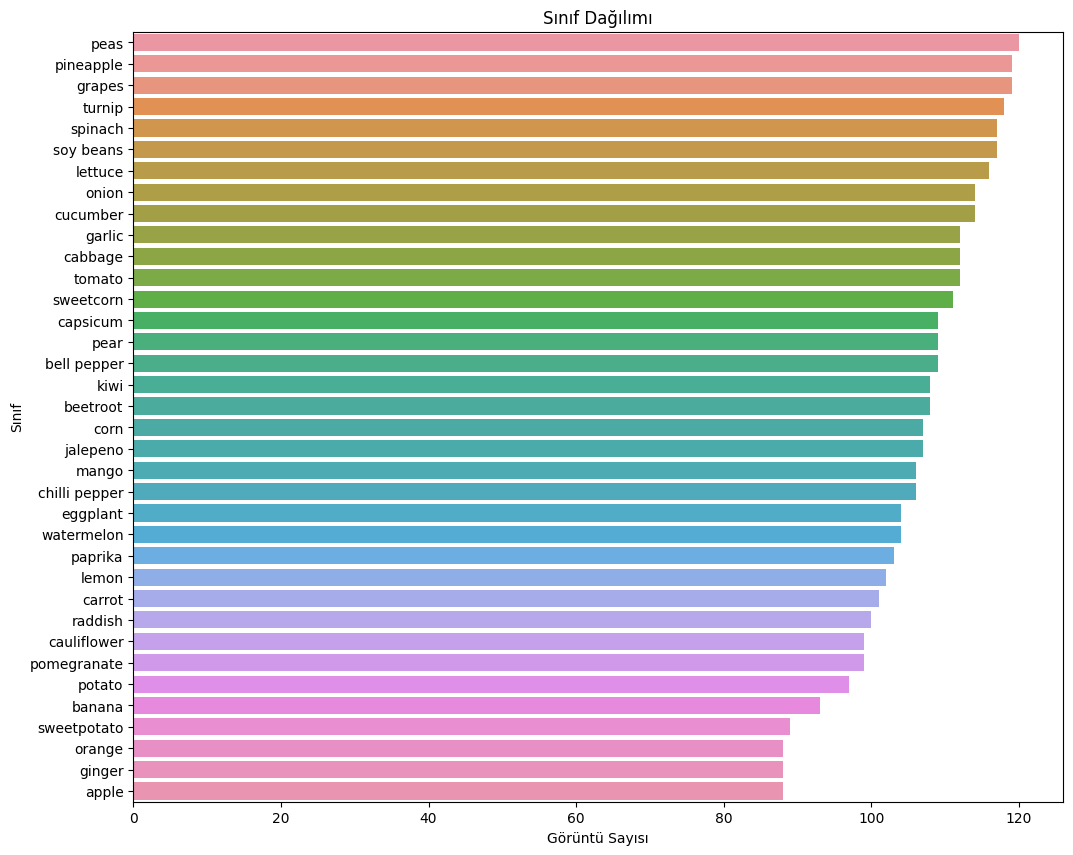

In [11]:
plt.figure(figsize=(12,10))
sns.countplot(y='label', data=df, order=df['label'].value_counts().index)
plt.title('Sınıf Dağılımı')
plt.xlabel('Görüntü Sayısı')
plt.ylabel('Sınıf')
plt.show()


HER GÖRSELİN BOYUTU VE FARKINI İNCELEMEMİZ GEREKİYOR

In [12]:
from PIL import Image
#Image sınıfı, resim dosyalarını açmak, oluşturmak ve üzerinde işlem yapmak için kullanılır.

In [13]:
widths = []
heights = []
formats = []

In [14]:
for path in df['filepath'][:1000]: 
    img = Image.open(path)
    widths.append(img.width)
    heights.append(img.height)
    formats.append(img.format)
    #1000 tane örnek alıyoruz ve img nesnesi kullanarak inceliyoruz

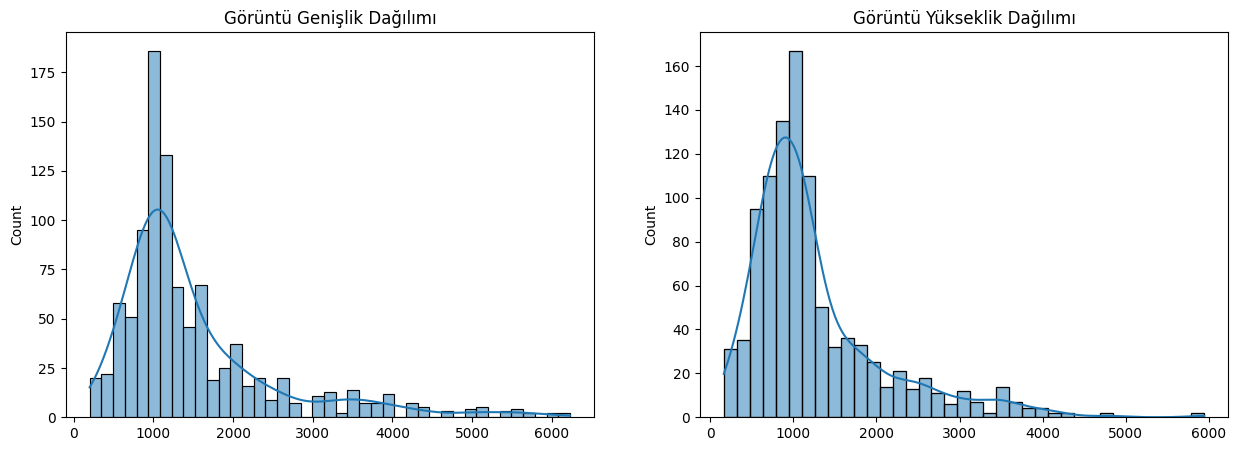

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(widths, kde=True)
plt.title('Görüntü Genişlik Dağılımı')

plt.subplot(1,2,2)
sns.histplot(heights, kde=True)
plt.title('Görüntü Yükseklik Dağılımı')
plt.show()

Her iki histogram da sağa doğru çarpık (skewed to the right) bir dağılım gösteriyor. Bu, veri setindeki görüntülerin çoğunluğunun belirli bir değer aralığında toplandığını, ancak az sayıda görüntünün çok daha büyük genişlik veya yükseklik değerlerine sahip olduğunu ifade eder.

In [16]:
pd.Series(formats).value_counts()

JPEG    963
PNG      37
Name: count, dtype: int64

os.path ile dosya uzantısına bakıyoruz ama Image kütüphanesi görüntüyü açıp gerçek format bilgisini döndürüyor.

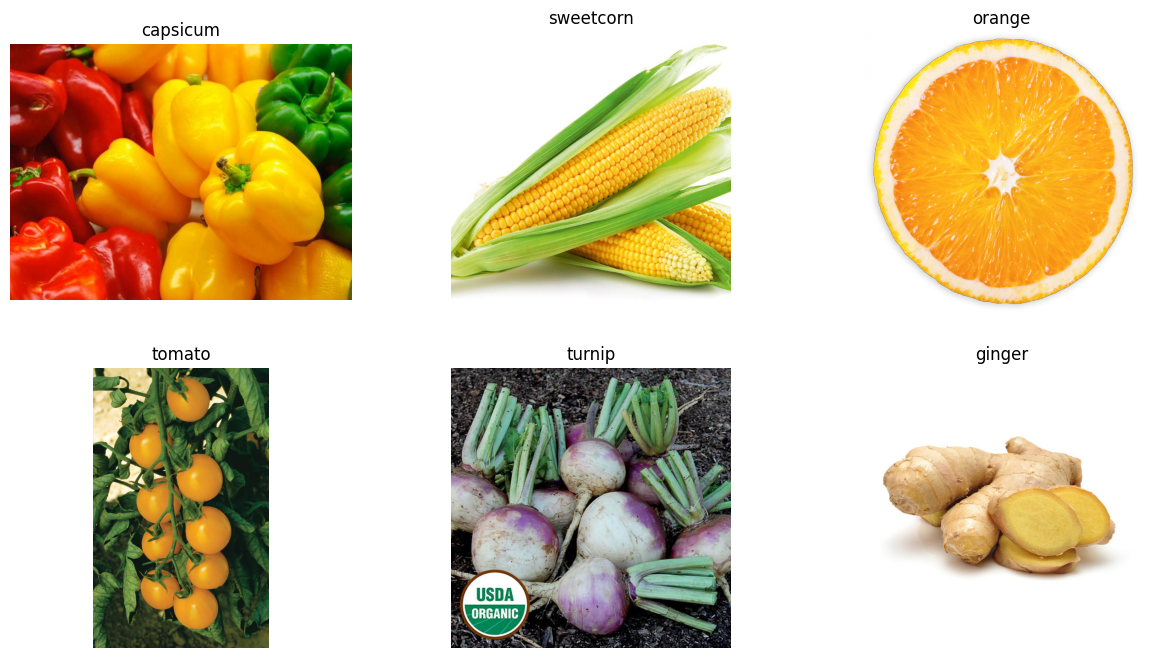

In [17]:
import random
classes = df['label'].unique()
plt.figure(figsize=(15,8))

for i, cls in enumerate(classes[:6]):  
    sample_path = random.choice(df[df['label']==cls]['filepath'].tolist())
    img = Image.open(sample_path)
    
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.show()

ilk 6 sınıftan rastgele resim çıkıyor ve bu sayede çeşitliliği görmüş oluyoruz.

In [18]:
#dosya uzunatıları
pd.Series([os.path.splitext(p)[1].lower() for p in df['filepath']]).value_counts()

.jpg     3535
.png      223
.jpeg      67
Name: count, dtype: int64

In [19]:
aspect_ratios = [w/h for w,h in zip(widths, heights)]


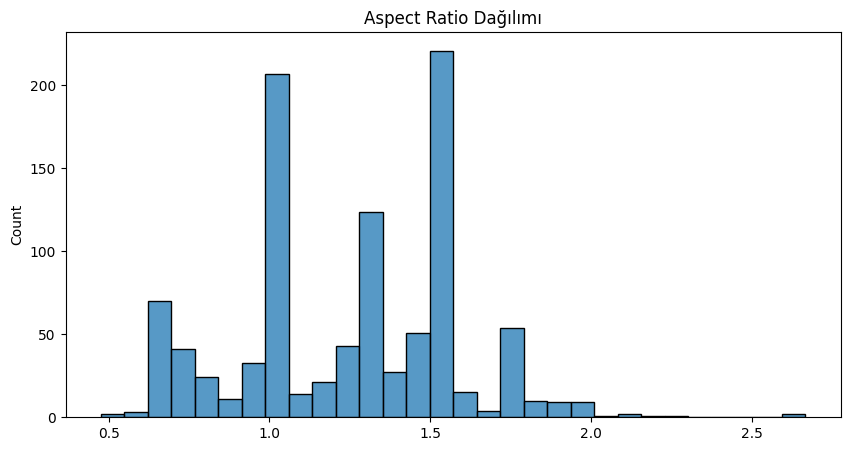

In [20]:
plt.figure(figsize=(10,5))
sns.histplot(aspect_ratios, bins=30)
plt.title("Aspect Ratio Dağılımı")
plt.show()


Görsellerin çoğu .jpg bazıları ise .jpeg ve .png. Modelimiz için bunları tek formata dönüştürücez. jpeg -> .jpg olarak değiştirebiliriz. .png görsellierini de .jpg'ye PIL ile kolayca dönüştürebiliriz. Böylece ImageDataGenerator veya PyTorch/TF Dataset pipeline’ında hata riskini azaltırız.

In [21]:
import shutil

output_dir = '/kaggle/working/fruit_veg_dataset'
os.makedirs(output_dir, exist_ok=True)

new_filepaths = []

for idx, row in df.iterrows():
    path = row['filepath']
    ext = os.path.splitext(path)[1].lower()
    
    # Görseli aç ve RGB’ye çevir
    img = Image.open(path).convert('RGB')
    
    # Yeni kaydetme yolu
    new_path = os.path.join(output_dir, f"{idx}.jpg")
    img.save(new_path)
    new_filepaths.append(new_path)

# DataFrame’i güncelle
df['filepath'] = new_filepaths


In [22]:
for idx, row in df.iterrows():
    path = row['filepath']
    ext = os.path.splitext(path)[1].lower()
    if ext in ['.png', '.jpeg']:
        img = Image.open(path).convert('RGB')
        new_path = os.path.splitext(path)[0] + '.jpg'
        img.save(new_path)
        df.at[idx, 'filepath'] = new_path

In [23]:
pd.Series([os.path.splitext(p)[1].lower() for p in df['filepath']]).value_counts()

.jpg    3825
Name: count, dtype: int64

şimdi tüm verilerimiz .jpg oldu. İşlemlerimize devam edebiliriz.

****Train / Validation / Test setlerine ayırma****
Bunun için sklearn kütüphanesini kullanıyoruz.


In [24]:

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# burada stratify kullanrak her sınıfın oranını koruyoruz ki modelimiz doğru sonuçlar versin.

In [25]:
print(train_df)

                                        filepath          label
2483  /kaggle/working/fruit_veg_dataset/2483.jpg        paprika
583    /kaggle/working/fruit_veg_dataset/583.jpg         grapes
383    /kaggle/working/fruit_veg_dataset/383.jpg         tomato
2964  /kaggle/working/fruit_veg_dataset/2964.jpg         banana
2959  /kaggle/working/fruit_veg_dataset/2959.jpg         banana
...                                          ...            ...
3151  /kaggle/working/fruit_veg_dataset/3151.jpg  chilli pepper
1787  /kaggle/working/fruit_veg_dataset/1787.jpg        lettuce
3386  /kaggle/working/fruit_veg_dataset/3386.jpg           peas
998    /kaggle/working/fruit_veg_dataset/998.jpg         tomato
3718  /kaggle/working/fruit_veg_dataset/3718.jpg        spinach

[3060 rows x 2 columns]


In [26]:
img_size = (128, 128)   # resimleri yeniden boyutlandırma
batch_size = 32

In [27]:
import tensorflow as tf

In [28]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)
# tüm görselleri 0-255 aralığında 0-1 aralığına ölçeklendirdik. bu işlem modelin daha hızlı ve 
# stabil öğrenmesi için standart bir ön işlmeme adımıdır.

#eğitim verileri
train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"   # çok sınıflı sınıflandırma
)
#doğrulama verileri
val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)
#test verileri
test_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 3060 validated image filenames belonging to 36 classes.
Found 382 validated image filenames belonging to 36 classes.
Found 383 validated image filenames belonging to 36 classes.


train seti 3060 görsel buldu ve toplamda 36 farklı sınıfa dağıttı.
validation setinde 382 görsel bulundu ve toplamda 36 farklı sınıfa dağıttı.
test setinde 383 görsel bulundu ve toplamda 36 farklı sınıfa dağıttı.

In [29]:
# Artık elimizde 3 tane generator var (train_gen, val_gen, test_gen), bunları oluşturacağmız CNN modeline verebiliriz.

CNN (Convolutional Neural Network) dediğimiz yapı görsellerden otomatik özellik çıkarma işini yapar.
Şu parçaları içerir:

***Conv Katmanı (Convolutional Layer):***

Görsellerde kenar, köşe, renk geçişi gibi özellikleri filtrelerle yakalar.

Örn: layers.Conv2D(32, (3,3), activation='relu')
→ 32 tane 3x3 filtre uygular, aktivasyon fonksiyonu ReLU.

***Pooling Katmanı (MaxPooling):***

Görselin boyutunu küçültür ama en önemli bilgileri korur.

Örn: layers.MaxPooling2D((2,2))
→ 2x2’lik pencereden maksimum değeri alır.

***Dropout Katmanı:***

Overfitting’i önlemek için bazı nöronları rastgele kapatır.

Örn: layers.Dropout(0.5) → %50’sini kapatır.

Flatten + Dense (Fully Connected):

Özellikleri düzleştirip (Flatten) klasik sinir ağına verir.

Dense(128, activation='relu') → gizli katman.

Dense(num_classes, activation='softmax') → çıktı katmanı, sınıfları tahmin eder.


In [30]:
num_classes = len(train_gen.class_indices)

from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),#görsellerden özellik çıkarımı yapıyor
    layers.MaxPooling2D((2,2)), # Görselleri küçültüp önemli özellikleri koruyor.

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),# flatten tek boyutlu vektöre çeviriyor dense katmanına bağlamk için
    layers.Dropout(0.5), #Modelin aşırı öğrenmesini (overfitting) önlemek için bazı nöronları rastgele kapatıyor. Eğer overfitting görürsek dropout oranını arttırabiliriz.
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # çıktı katmanı
])


I0000 00:00:1758920070.386136      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758920070.386900      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [31]:
#modeli derleme 
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


modeli eğitme

In [32]:
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen
)


Epoch 1/20


I0000 00:00:1758920075.969941      64 service.cc:148] XLA service 0x7e4ad40041e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758920075.970804      64 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758920075.970830      64 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758920076.355497      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/96 ━━━━━━━━━━━━━━━━━━━━ 11:37 7s/step - accuracy: 0.0312 - loss: 3.5513

I0000 00:00:1758920080.180700      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


96/96 ━━━━━━━━━━━━━━━━━━━━ 55s 500ms/step - accuracy: 0.0573 - loss: 3.4148 - val_accuracy: 0.2435 - val_loss: 2.6559
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 435ms/step - accuracy: 0.2762 - loss: 2.4661 - val_accuracy: 0.3822 - val_loss: 2.1354
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 426ms/step - accuracy: 0.4084 - loss: 1.9793 - val_accuracy: 0.4921 - val_loss: 1.8177
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 431ms/step - accuracy: 0.5144 - loss: 1.6687 - val_accuracy: 0.5419 - val_loss: 1.6327
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 432ms/step - accuracy: 0.5862 - loss: 1.3957 - val_accuracy: 0.5576 - val_loss: 1.6898
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 435ms/step - accuracy: 0.6368 - loss: 1.2013 - val_accuracy: 0.5864 - val_loss: 1.5364
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 440ms/step - accuracy: 0.7242 - loss: 0.9407 - val_accuracy: 0.5733 - val_loss: 1.6161
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 432ms/step - accuracy: 0.7584 - loss: 0.7914 - val_accuracy: 0.591

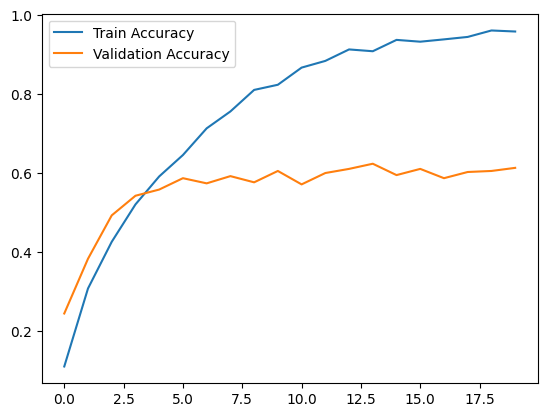

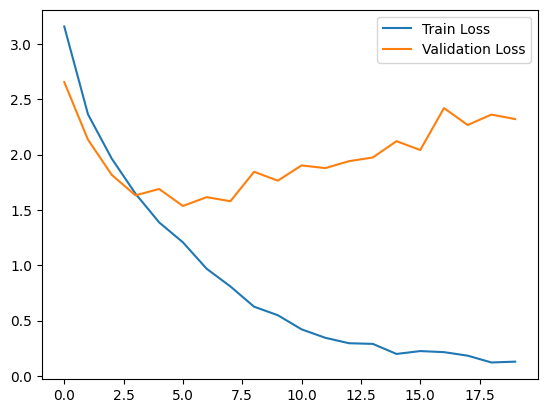

In [33]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


modelimiz aşırı öğrenmeye uğradı yani eğitim doğruluğu hızla artıyor ama doğrulama doğruluğu 55-60 civarında takılı kalıyor. Validation loss ise özellikle 5. epoch dan sonra artmaya başlıyor. Modelimiz sıfırdan öğrendiği için düşük bir doğruluk kazandı. Çünkü dataset karmaşık ve çok sınıflı. EfficientNet / MobileNet / ResNet gibi hazır modeller kullanamyı deneyelim.

In [34]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.2f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 427ms/step - accuracy: 0.5509 - loss: 2.5198
Test Accuracy: 0.57


In [35]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [36]:
img_size = (128, 128)
batch_size = 32

In [37]:
# Train için augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [38]:
# Validation & Test için sadece normalize
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [39]:
# DataFrame üzerinden okuma
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)
val_gen = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_gen = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 3060 validated image filenames belonging to 36 classes.
Found 382 validated image filenames belonging to 36 classes.
Found 383 validated image filenames belonging to 36 classes.


In [40]:
num_classes = len(train_gen.class_indices)

In [41]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128,128,3))
base_model.trainable = False   # önce dondur

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [42]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# İlk Eğitim (Feature Extraction)
history = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen
)

Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 74s 648ms/step - accuracy: 0.1335 - loss: 3.4425 - val_accuracy: 0.6728 - val_loss: 1.3233
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 51s 533ms/step - accuracy: 0.5186 - loss: 1.6764 - val_accuracy: 0.7042 - val_loss: 0.9027
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 51s 528ms/step - accuracy: 0.6095 - loss: 1.2723 - val_accuracy: 0.7382 - val_loss: 0.7986
Epoch 4/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 51s 531ms/step - accuracy: 0.6633 - loss: 1.1431 - val_accuracy: 0.7618 - val_loss: 0.7510
Epoch 5/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 52s 537ms/step - accuracy: 0.6949 - loss: 0.9725 - val_accuracy: 0.7670 - val_loss: 0.6959
Epoch 6/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 553ms/step - accuracy: 0.7129 - loss: 0.8772 - val_accuracy: 0.7696 - val_loss: 0.6848
Epoch 7/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 52s 546ms/step - accuracy: 0.7371 - loss: 0.8293 - val_accuracy: 0.7670 - val_loss: 0.6809
Epoch 8/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 55s 566ms/step - accuracy: 0.7458 - loss: 0.7842 - val_accu

In [43]:
#fine turning
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # küçük LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 142s 815ms/step - accuracy: 0.4816 - loss: 1.8611 - val_accuracy: 0.7775 - val_loss: 0.6607
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 555ms/step - accuracy: 0.5763 - loss: 1.4444 - val_accuracy: 0.7670 - val_loss: 0.6842
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 577ms/step - accuracy: 0.5928 - loss: 1.3305 - val_accuracy: 0.7696 - val_loss: 0.6828
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 555ms/step - accuracy: 0.6262 - loss: 1.1849 - val_accuracy: 0.7723 - val_loss: 0.6836
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 555ms/step - accuracy: 0.6639 - loss: 1.0803 - val_accuracy: 0.7696 - val_loss: 0.6884
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 54s 563ms/step - accuracy: 0.6821 - loss: 1.0016 - val_accuracy: 0.7827 - val_loss: 0.6852
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 549ms/step - accuracy: 0.6962 - loss: 0.9593 - val_accuracy: 0.7827 - val_loss: 0.6820
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 54s 556ms/step - accuracy: 0.7007 - loss: 0.9369 - val_acc

In [44]:
loss, acc = model.evaluate(test_gen)
print("Test Accuracy:", acc)

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 648ms/step - accuracy: 0.8006 - loss: 0.7486
Test Accuracy: 0.7650130391120911


***modelimizin doğruluğunu arttırmak için data augmentation'u zenginleştirebiliriz***

In [45]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [46]:
img_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

In [47]:
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_gen = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_gen = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 3060 validated image filenames belonging to 36 classes.
Found 382 validated image filenames belonging to 36 classes.
Found 383 validated image filenames belonging to 36 classes.


In [48]:
num_classes = len(train_gen.class_indices)

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128,128,3))
base_model.trainable = False  # İlk etapta dondur

In [49]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(num_classes, activation="softmax")
])


In [50]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
lr_schedule = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)


history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=[early_stop, lr_schedule]
)

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 80s 690ms/step - accuracy: 0.1473 - loss: 3.5633 - val_accuracy: 0.6257 - val_loss: 1.4337 - learning_rate: 0.0010
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 581ms/step - accuracy: 0.4704 - loss: 1.9228 - val_accuracy: 0.7120 - val_loss: 1.0400 - learning_rate: 0.0010
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 580ms/step - accuracy: 0.5545 - loss: 1.5663 - val_accuracy: 0.7068 - val_loss: 0.8956 - learning_rate: 0.0010
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 55s 576ms/step - accuracy: 0.5970 - loss: 1.3615 - val_accuracy: 0.7408 - val_loss: 0.8496 - learning_rate: 0.0010
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 57s 594ms/step - accuracy: 0.6406 - loss: 1.2112 - val_accuracy: 0.7565 - val_loss: 0.8398 - learning_rate: 0.0010
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 582ms/step - accuracy: 0.6534 - loss: 1.1638 - val_accuracy: 0.7618 - val_loss: 0.8084 - learning_rate: 0.0010
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 577ms/step - accuracy: 0.6485 - loss: 1.

In [52]:
# Fine-tuning için base_model'i açıyoruz
base_model.trainable = True  

# Yeni optimizer tanımla 
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning eğitim 
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,               # toplam epoch
    initial_epoch=history.epoch[-1],  # önceki eğitimden kaldığın yerden devam
    callbacks=[early_stop, lr_schedule]
)


Epoch 20/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 145s 855ms/step - accuracy: 0.4732 - loss: 1.9631 - val_accuracy: 0.7775 - val_loss: 0.7308 - learning_rate: 1.0000e-05
Epoch 21/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 583ms/step - accuracy: 0.5418 - loss: 1.5876 - val_accuracy: 0.7513 - val_loss: 0.8063 - learning_rate: 1.0000e-05
Epoch 22/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 55s 574ms/step - accuracy: 0.5590 - loss: 1.4410 - val_accuracy: 0.7487 - val_loss: 0.8313 - learning_rate: 1.0000e-05
Epoch 23/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.6230 - loss: 1.2663
Epoch 23: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 582ms/step - accuracy: 0.6230 - loss: 1.2664 - val_accuracy: 0.7382 - val_loss: 0.8219 - learning_rate: 1.0000e-05
Epoch 24/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 55s 573ms/step - accuracy: 0.6196 - loss: 1.2698 - val_accuracy: 0.7408 - val_loss: 0.8008 - learning_rate: 5.0000e-06
Epoch 25/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 581ms/step - a

In [53]:
loss, acc = model.evaluate(test_gen)
print("Test Accuracy:", acc)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 546ms/step - accuracy: 0.7559 - loss: 0.6973
Test Accuracy: 0.767624020576477


In [54]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [55]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 # %20 validation
)


In [56]:
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Pretrained Model: MobileNetV2
base_model = MobileNetV2(input_shape=(128,128,3), include_top=False, weights="imagenet")
base_model.trainable = False  # önce sadece üst katmanları eğitelim

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(train_generator.num_classes, activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True)


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)

Found 3061 images belonging to 3 classes.
Found 764 images belonging to 3 classes.
Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.6018 - loss: 1.2672 - val_accuracy: 0.8141 - val_loss: 0.7109
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.7448 - loss: 0.8598 - val_accuracy: 0.8141 - val_loss: 0.6717
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.7849 - loss: 0.7471 - val_accuracy: 0.8168 - val_loss: 0.6242
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.7955 - loss: 0.6866 - val_accuracy: 0.8154 - val_loss: 0.6220
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.7967 - loss: 0.7025 - val_accuracy: 0.8154 - val_loss: 0.6440
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.8002 - loss: 0.6864 - val_accuracy: 0.8154 - val_loss: 0.6159
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.7911 - loss: 0.6875 - val_accuracy: 0.8154 - val_loss: 0.6270
Epoch 8/20
96/96 ━━━━━━━━━━━

In [57]:
loss, acc = model.evaluate(val_generator)
print("Validation/Test Accuracy:", acc)
print("Validation/Test Loss:", loss)


24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 901ms/step - accuracy: 0.7041 - loss: 0.8184
Validation/Test Accuracy: 0.8154450058937073
Validation/Test Loss: 0.6207568645477295


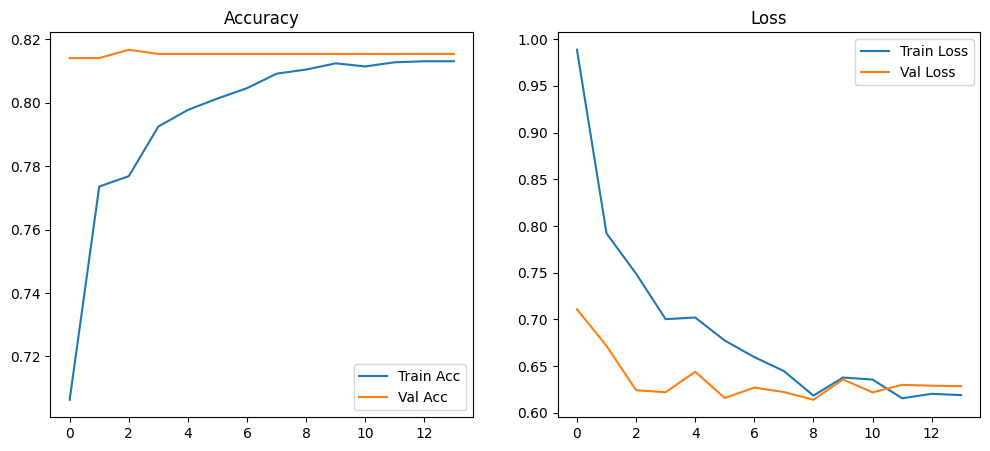

In [58]:
# Accuracy & Loss grafikleri
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step


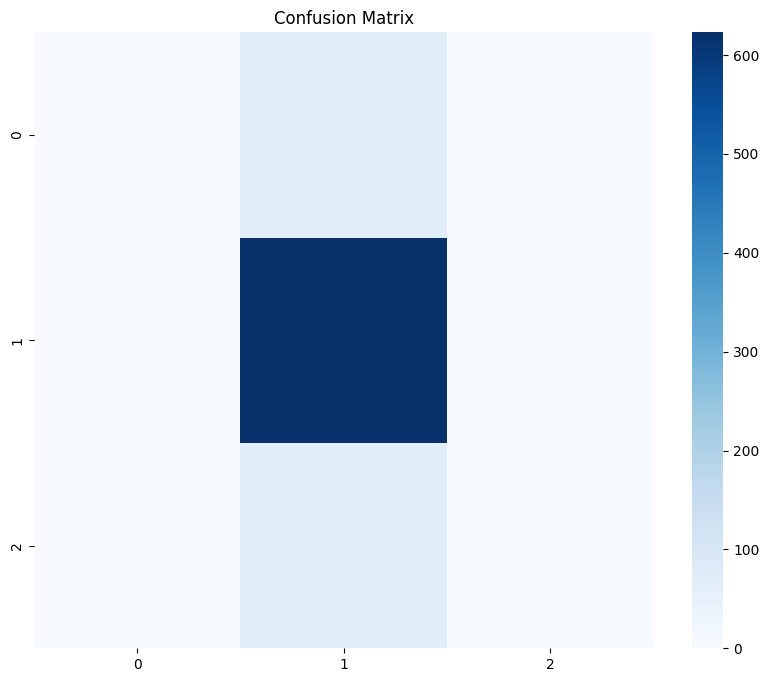

In [59]:
y_true = val_generator.classes
y_pred = np.argmax(model.predict(val_generator), axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()